### Setting Up Environment


In [1]:
import torch
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path

from torch.utils.data import DataLoader


In [2]:
data_path = Path("DATASET/")

train_image_dir = data_path / "TRAIN"
test_image_dir = data_path / "TEST"

train_image_dir, test_image_dir


(WindowsPath('DATASET/TRAIN'), WindowsPath('DATASET/TEST'))

### Visualize Image

In [3]:
import os

for dirpath, dirname, filename in os.walk(data_path):
    print(dirpath, dirname, len(filename))



DATASET ['TEST', 'TRAIN'] 0
DATASET\TEST ['Organic', 'Recyclable'] 0
DATASET\TEST\Organic [] 1401
DATASET\TEST\Recyclable [] 1112
DATASET\TRAIN ['Organic', 'Recyclable'] 0
DATASET\TRAIN\Organic [] 12565
DATASET\TRAIN\Recyclable [] 9999


In [4]:
import random
from PIL import Image

# Set random seet
image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

sample_path_list = random.sample(image_path_list, k=10)
sample_path_list



[WindowsPath('DATASET/TEST/Recyclable/R_10152.jpg'),
 WindowsPath('DATASET/TEST/Organic/O_12617.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_8747.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_1749.jpg'),
 WindowsPath('DATASET/TEST/Organic/O_13335.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_6220.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_556.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_904.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_8633.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_9604.jpg')]

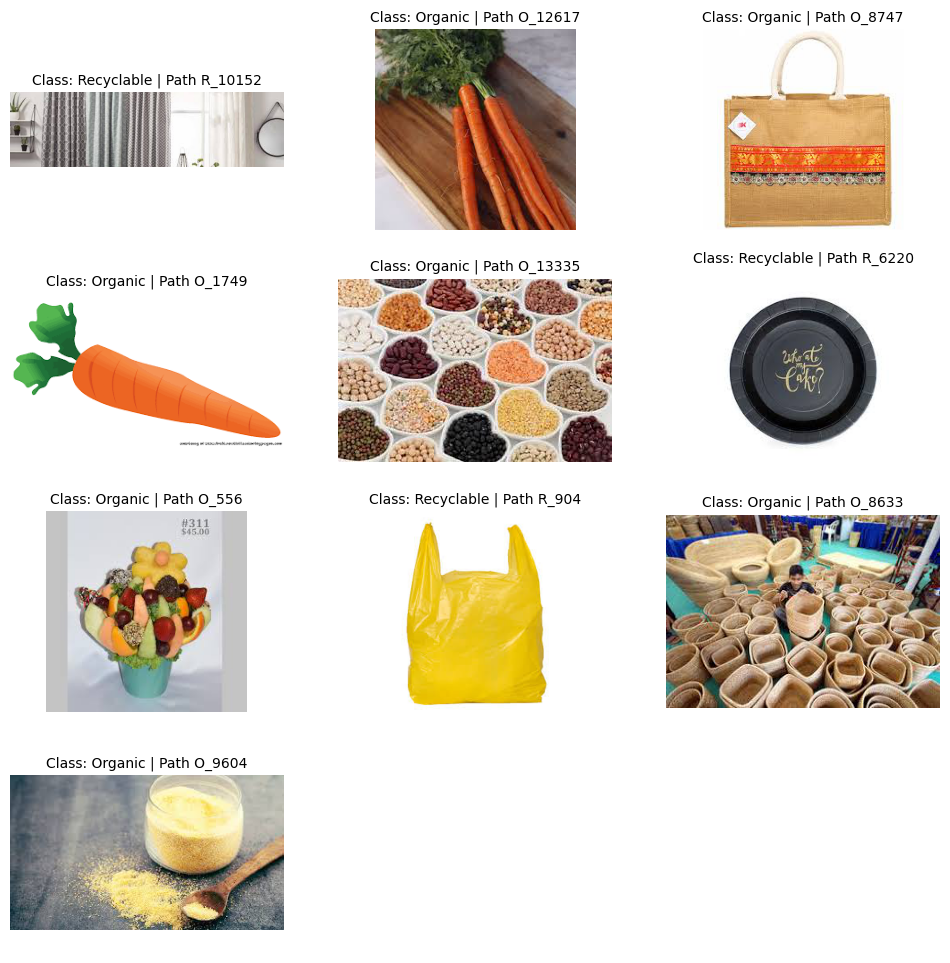

In [11]:
import matplotlib.image as mpimg

def display_image_in_grid(image_paths, grid_size=(4,3)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12,12))

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < num_images:
            image_path = image_paths[i]
            image = mpimg.imread(image_path)
            ax.imshow(image)
            ax.set_title(f"Class: {image_paths[i].parent.stem} | Path {image_paths[i].stem}", fontsize=10)
        

display_image_in_grid(sample_path_list)

DATASET\TEST\Recyclable\R_10152.jpg
DATASET\TEST\Organic\O_12617.jpg
DATASET\TRAIN\Organic\O_8747.jpg
DATASET\TRAIN\Organic\O_1749.jpg
DATASET\TEST\Organic\O_13335.jpg
DATASET\TRAIN\Recyclable\R_6220.jpg
DATASET\TRAIN\Organic\O_556.jpg
DATASET\TRAIN\Recyclable\R_904.jpg
DATASET\TRAIN\Organic\O_8633.jpg
DATASET\TRAIN\Organic\O_9604.jpg


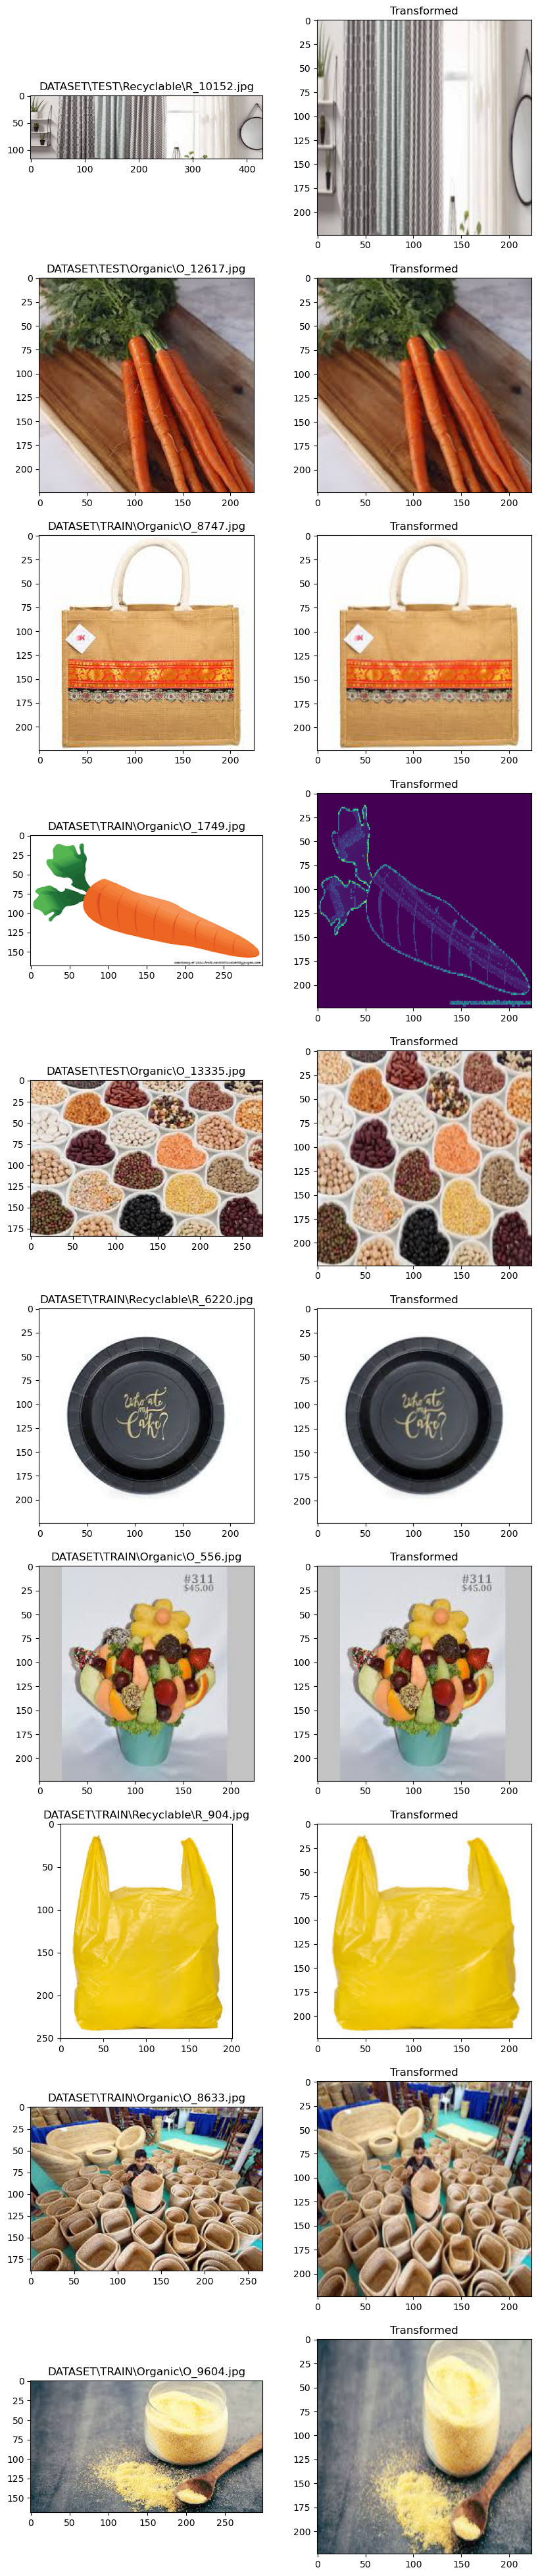

In [19]:
import matplotlib.image as mpimg
from PIL import Image
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

def display_image_before_after_transform(image_paths, transform, grid_size=(10,2)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 5*grid_size[0]))

    for i, ax_row in enumerate(axes):
        image_path = image_paths[i]
        print(image_path)
        for j, ax in enumerate(ax_row):
            # ax.set_title(f"Row: {i} | Col: {j} | Index: {i*2+j}")

            if j == 0:                
                image = mpimg.imread(image_path)
                ax.set_title(f"{image_path}")
                ax.imshow(image)
            else:
                image = Image.open(image_path)
                transformed_image = transform(image).permute(1,2,0) # Convert (C x H x W) to (H x W x C)
                ax.set_title(f"Transformed")
                ax.imshow(transformed_image)        
        

display_image_before_after_transform(sample_path_list, image_transform)

In [20]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=image_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=image_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 22564
    Root location: DATASET\TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

!nvidia-smi

cuda
Wed Feb 28 15:02:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8               1W /  80W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [22]:
class_name = train_data.classes
class_name_idx = train_data.class_to_idx

print(class_name, class_name_idx)

['Organic', 'Recyclable'] {'Organic': 0, 'Recyclable': 1}


In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

## Create Model

In [48]:
from torch import nn

class TinyVGGModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape:int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_unit * 56 * 56,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x = self.conv_block1(x)
        print(x.shape)
        x = self.conv_block2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        
        return x

In [49]:
torch.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        hidden_unit=10,
                        output_shape=len(class_name)).to(device)
model_0

TinyVGGModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=2, bias=True)
  )
)

In [50]:
image_batch, label_batch = next(iter(train_dataloader))

image_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]

In [51]:
image_single.shape

torch.Size([1, 3, 224, 224])

In [52]:
y_single = model_0(image_single.to(device))

torch.Size([1, 10, 112, 112])
torch.Size([1, 10, 56, 56])
torch.Size([1, 2])
